In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random
import itertools



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
#TODO: add more suffixes and make plots!
# Specifically with nohostdownweighted and see...

In [3]:
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p05" #
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p02" #

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p01" #
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p1" # need smaller jitter
suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # !! Really nice. Same/better results with less PCs. 98% var.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good, better than 35pca (best PC implementation)

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20"

In [4]:
dataset_bank_pca = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca.csv', compression='gzip', index_col=0)
dataset_bank_test = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca_test.csv', compression='gzip', index_col=0)
dataset_bank_orig = pd.read_pickle('../dataframes/dataset_label_orig_SMOTE_train_test_80-20_addJiterNorm0p02.pkl')

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)


In [5]:
dataset_bank_test['tns_cls'] = full_ann_properties_df['ann=0_tns_cls']

dataset_bank_pca['tns_cls'] = dataset_bank_orig
dataset_bank_pca

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF19ackimld   0.860577  0.347102 -0.086129  3.088369  2.083618 -0.445073   
ZTF20acoxdas  -0.738600 -0.283183 -0.169594 -0.218910 -0.833999  0.191610   
ZTF20acibvgy   2.143283 -1.335012 -0.512622  0.095665  0.267022  0.105054   
ZTF20acbrlih  -0.581914 -1.822116  0.028570  0.647441  0.185515 -1.114077   
ZTF19aadfqfw   0.502014 -0.296044 -1.664767 -1.059697 -0.226196  0.842061   
...                 ...       ...       ...       ...       ...       ...   
ZTFabc81758    1.326917  0.221507 -0.984746  1.546108  0.510162 -0.385631   
ZTFabc29325   -1.019785  1.947830  0.354130  1.910656  0.528188 -0.393346   
ZTFabc64209   -1.374340  1.560241  0.681835  0.445207 -0.612018 -0.063304   
ZTFabc62396    0.154766  0.425351  0.870779 -0.442114 -0.394210  0.881172   
ZTFabc16201   -0.939338  2.468846  0.486680  2.078274  0.813078 -0.520110   

                    PC6       PC7       PC8       PC9  ...      PC26  \
ztf_object_id                                          ...             
ZTF19ackimld   0.344285 -0.326433 -0.916704  0.019523  ...  0.343799   
ZTF20acoxdas  -0.117774  0.303070 -0.153738 -0.333301  ...  0.064632   
ZTF20acibvgy   0.151598  0.921186 -0.422336 -0.132782  ... -0.026186   
ZTF20acbrlih   0.844493 -0.751463 -0.540016  0.271147  ...  0.098870   
ZTF19aadfqfw   0.673194  0.675972 -0.506149 -0.656739  ...  0.091257   
...                 ...       ...       ...       ...  ...       ...   
ZTFabc81758   -0.126077  0.060087  0.114898  0.177693  ... -0.031674   
ZTFabc29325    0.236157  0.332813 -0.122777  0.329541  ... -0.188251   
ZTFabc64209    0.222289  0.321553 -0.389528 -0.380639  ... -0.113480   
ZTFabc62396   -0.748745  0.958788  0.104238 -0.147247  ... -0.123925   
ZTFabc16201    0.073386  0.421620  0.001284  0.358793  ... -0.259925   

                   PC27      PC28      PC29      PC30      PC31      PC32  \
ztf_object_id                                                               
ZTF19ackimld  -0.035568 -0.282303  0.321633 -0.029223  0.170370 -0.209342   
ZTF20acoxdas  -0.041385  0.096526 -0.087060 -0.093925 -0.033311 -0.017461   
ZTF20acibvgy   0.087542  0.170933  0.038563  0.193452  0.037454  0.206313   
ZTF20acbrlih   0.009624  0.157011 -0.182367 -0.133712 -0.185016  0.007324   
ZTF19aadfqfw  -0.372427 -0.040266 -0.312899 -0.193547  0.304349 -0.015038   
...                 ...       ...       ...       ...       ...       ...   
ZTFabc81758    0.075182  0.125095 -0.168459 -0.059493  0.013536 -0.027401   
ZTFabc29325   -0.052945 -0.051836 -0.127806 -0.053486  0.020130  0.103631   
ZTFabc64209   -0.092849  0.035423  0.079603  0.119513  0.049157  0.080057   
ZTFabc62396    0.068765 -0.233424 -0.064867 -0.043840 -0.122279 -0.062700   
ZTFabc16201   -0.059644 -0.080397 -0.133288 -0.050085  0.007585  0.076914   

                   PC33      PC34  tns_cls  
ztf_object_id                               
ZTF19ackimld  -0.174576  0.244648     None  
ZTF20acoxdas  -0.060328 -0.000739    SN Ia  
ZTF20acibvgy   0.089146  0.263067     None  
ZTF20acbrlih  -0.260107 -0.132189     None  
ZTF19aadfqfw   0.298485  0.012603     None  
...                 ...       ...      ...  
ZTFabc81758    0.016124  0.017825      TDE  
ZTFabc29325   -0.144311 -0.032134      TDE  
ZTFabc64209    0.020476  0.003561      TDE  
ZTFabc62396   -0.169664 -0.024025      TDE  
ZTFabc16201   -0.147943 -0.053366      TDE  

[35445 rows x 36 columns]

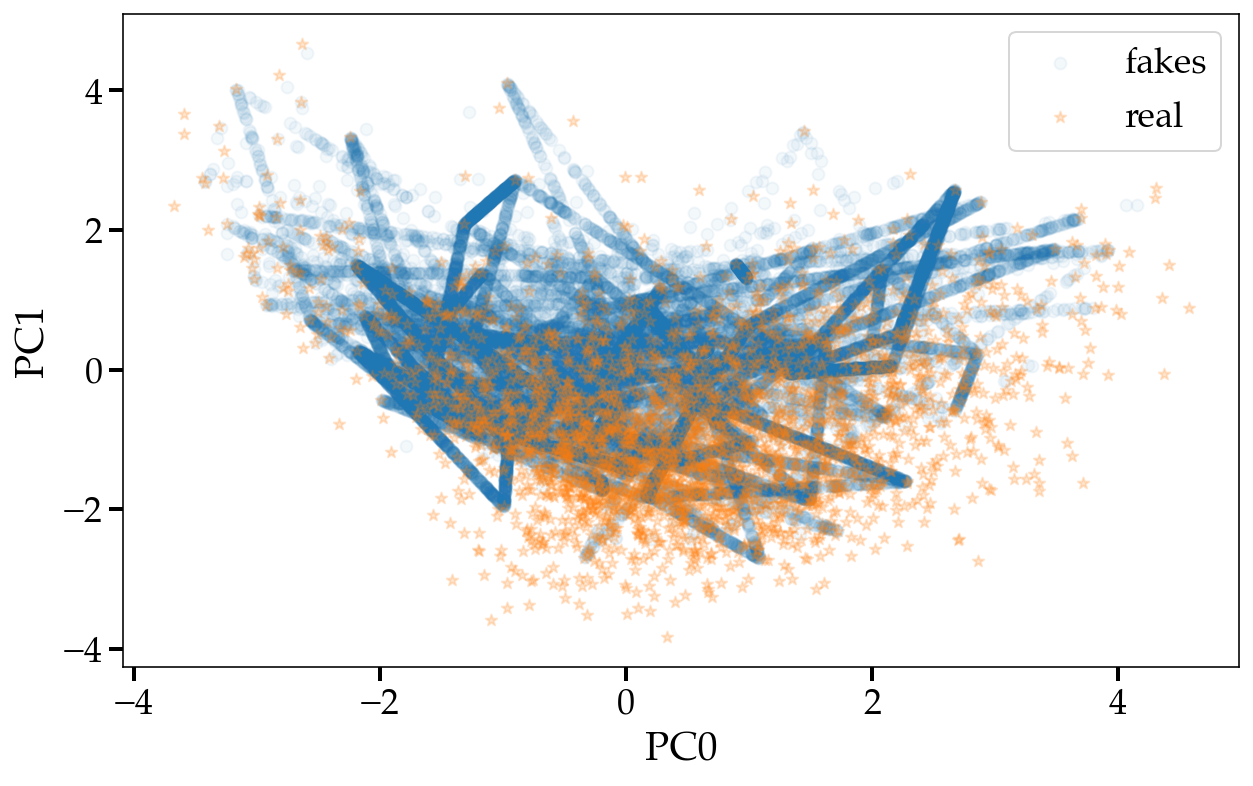

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend()
plt.show()

In [7]:
marker = itertools.cycle(('.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd')) 

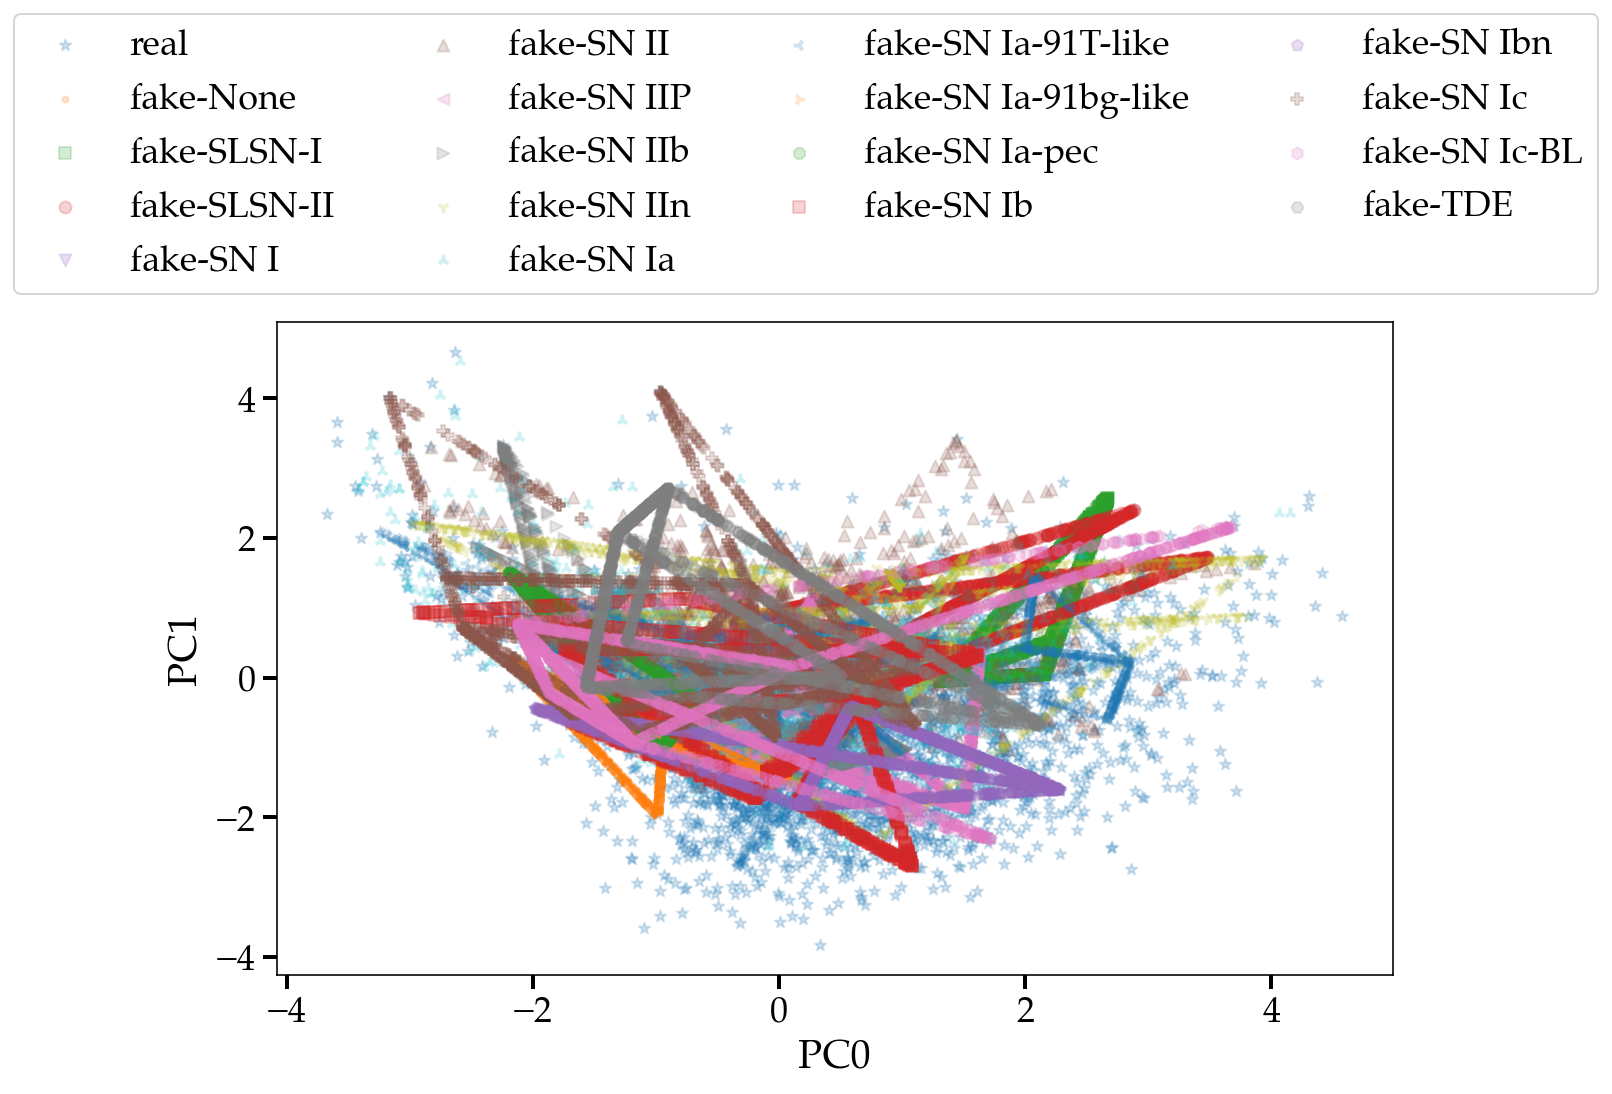

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    fakes_cls_df = fakes_df[fakes_df.tns_cls == cls]
    ax.scatter(fakes_cls_df['PC0'], fakes_cls_df['PC1'], alpha=0.2, marker=marker, label=f'fake-{cls}')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))

folder_path = f"../figures/principal_components/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/principal_components/{suffix}/fakes_cls_df.jpg', dpi=250, bbox_inches='tight')
plt.show()

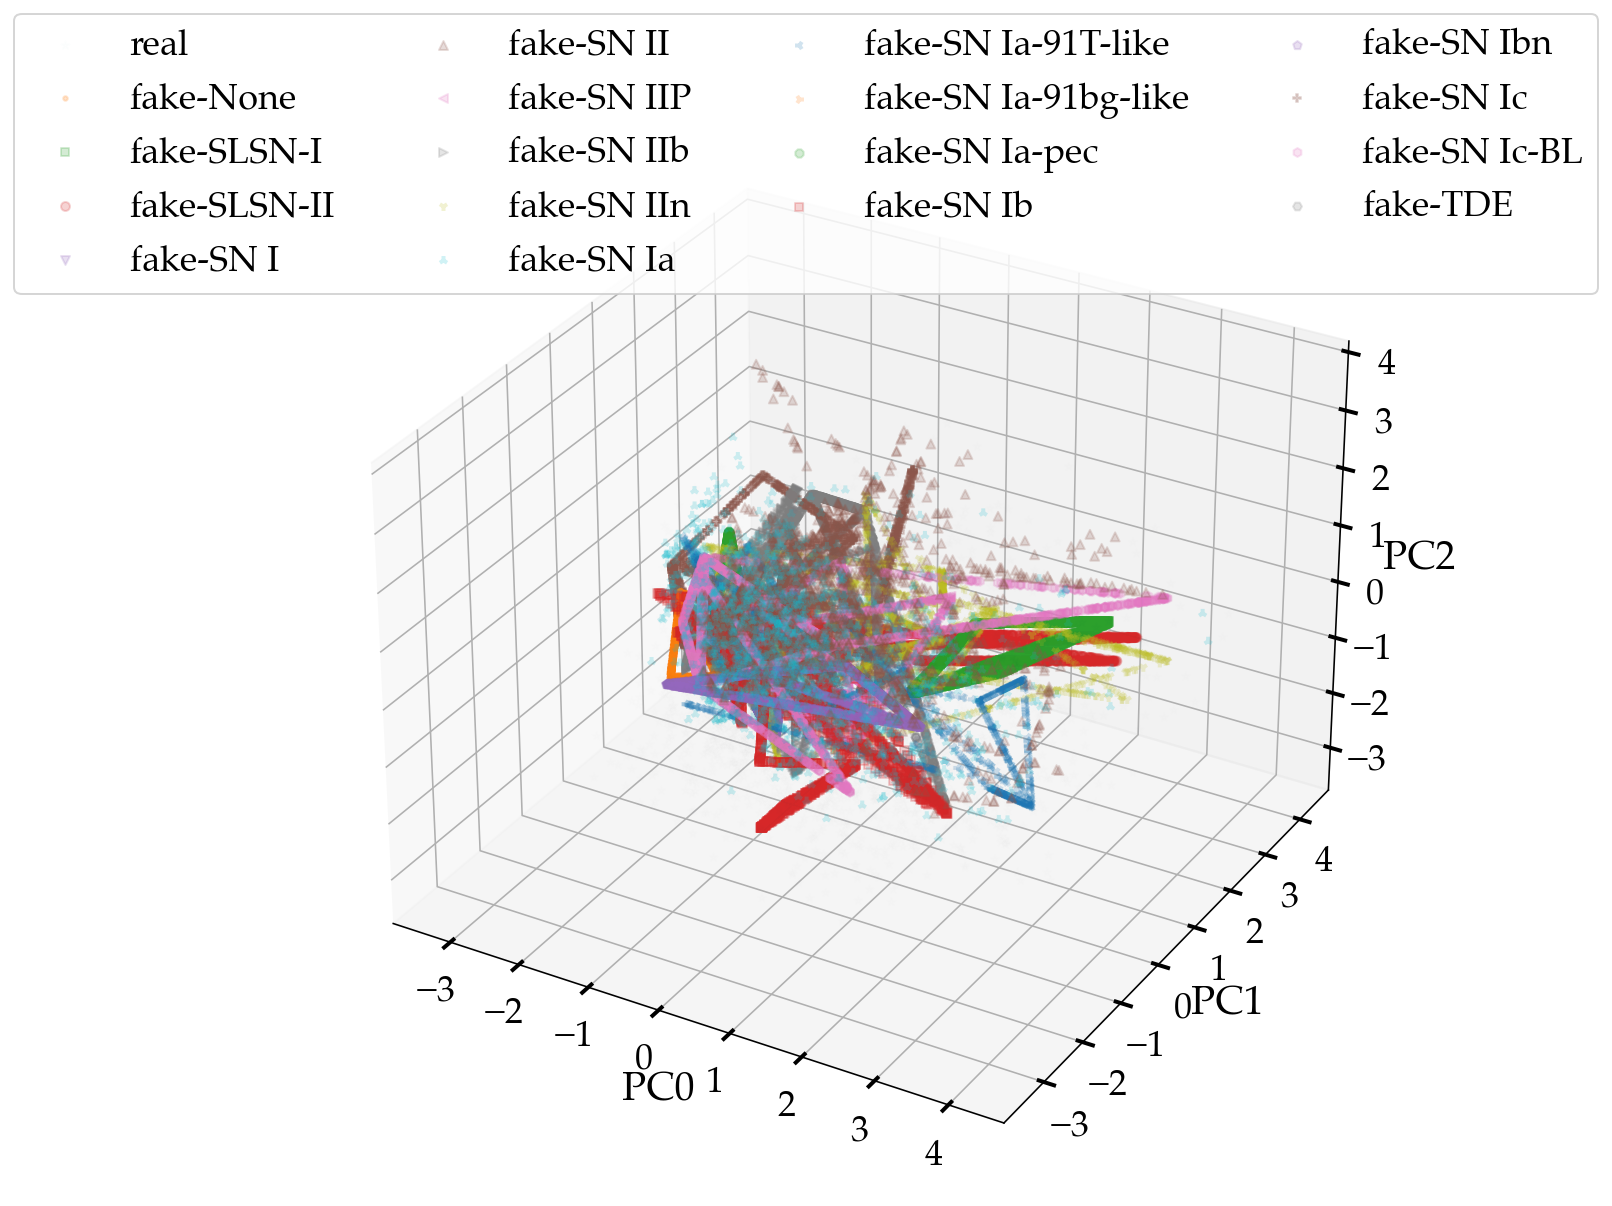

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(real_df['PC0'], real_df['PC1'], real_df['PC2'], alpha=0.005, marker='*',label='real')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    fakes_cls_df = fakes_df[fakes_df.tns_cls == cls]
    ax.scatter(fakes_cls_df['PC0'], fakes_cls_df['PC1'], fakes_cls_df['PC2'], alpha=0.2, marker=marker, label=f'fake-{cls}')

# Set axis limits
ax.set_xlim(real_df['PC0'].min(), real_df['PC0'].max())
ax.set_ylim(real_df['PC1'].min(), real_df['PC1'].max())
ax.set_zlim(real_df['PC2'].min(), real_df['PC2'].max())    
    
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.1))

folder_path = f"../figures/principal_components/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/principal_components/{suffix}/fakes_cls_df_3D.jpg', dpi=250, bbox_inches='tight')
plt.show()

In [10]:
# not upsampling None (no fakes), and few Ia fakes, so fakes doesn't cover all regions
# But fakes does cover outlier regions
# streaks are from extreme upsampling of O(few) instances of minority classes with 2knn

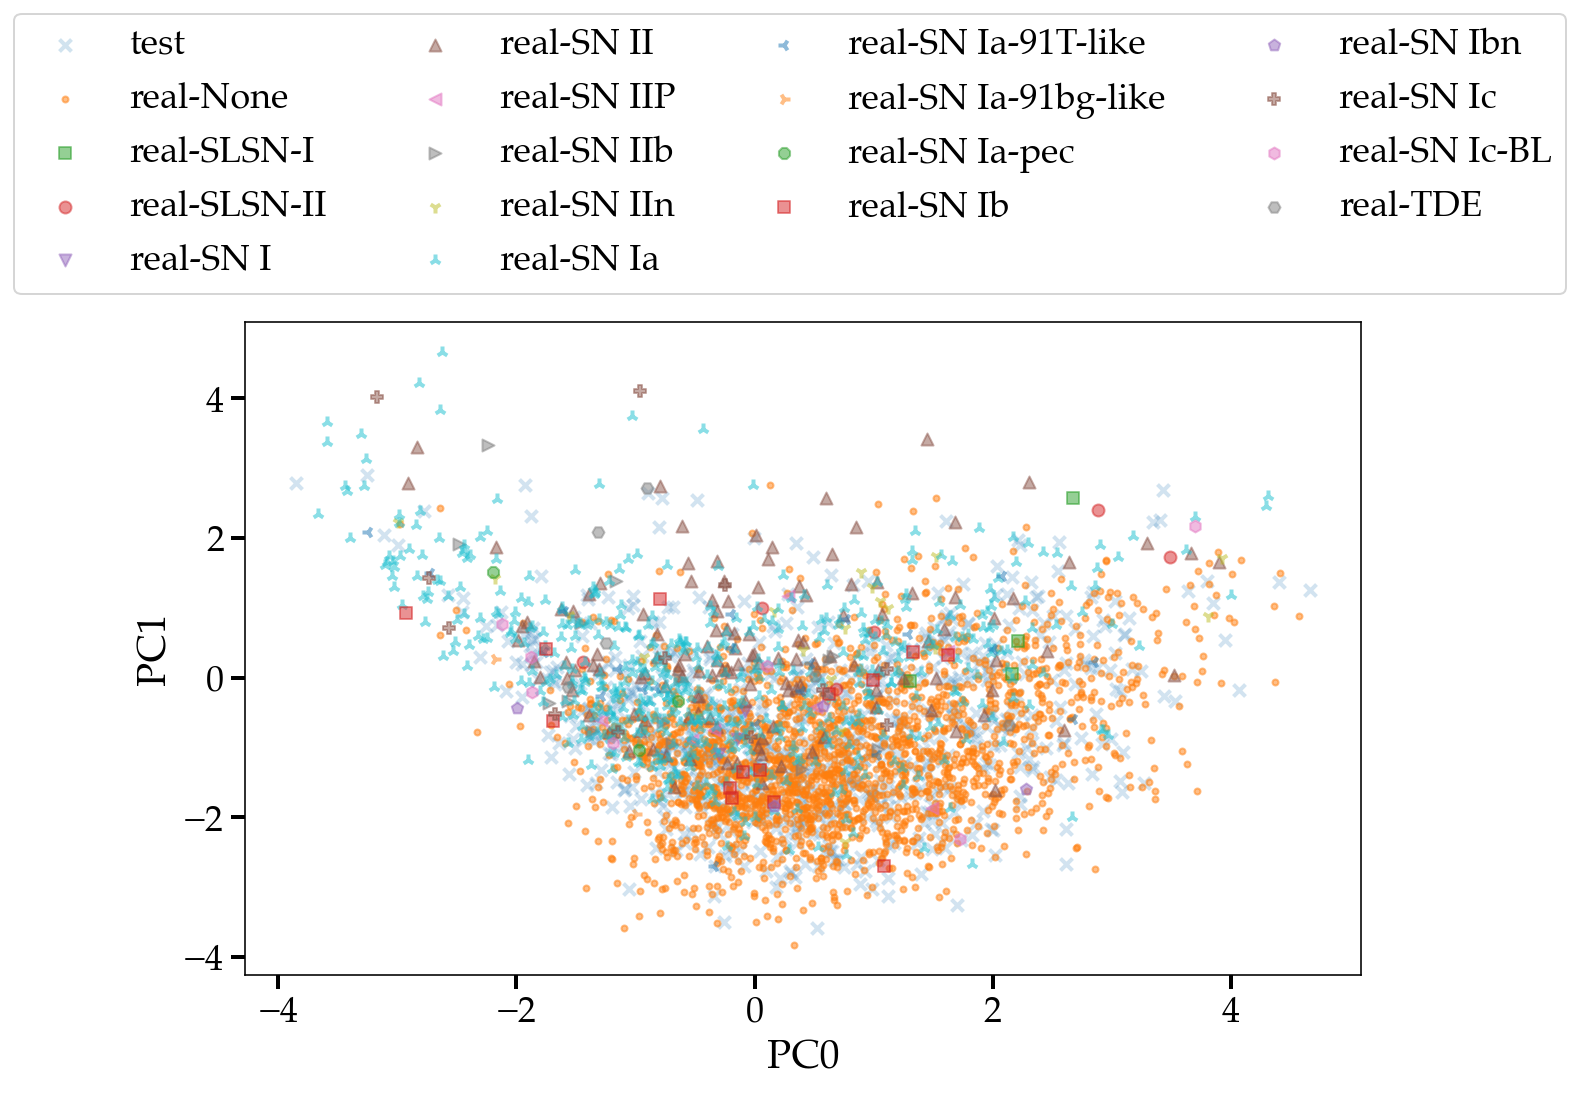

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.2, marker='x',label='test')


marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.5, marker=marker, label=f'real-{cls}')

#ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
#ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df.jpg', dpi=250, bbox_inches='tight')
plt.show()

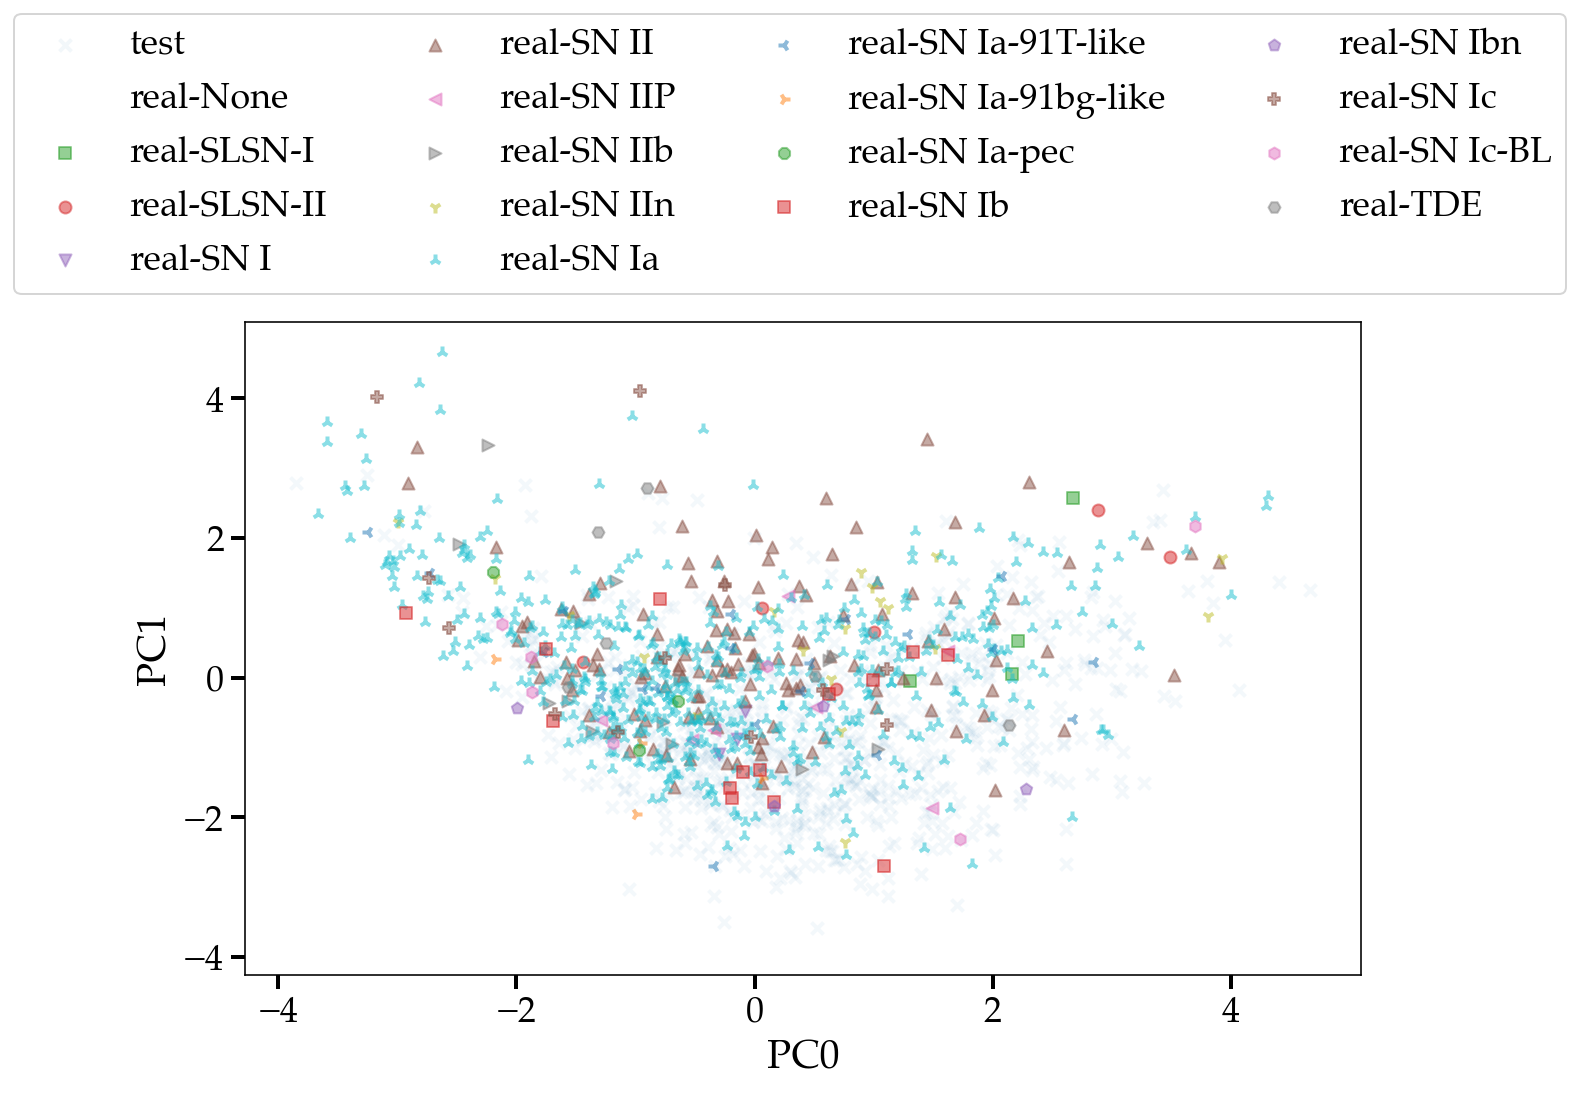

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')


marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    
    if cls == 'None': ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.0, marker=marker, label=f'real-{cls}')
    else: ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.5, marker=marker, label=f'real-{cls}')

#ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
#ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df_no_real.jpg', dpi=250, bbox_inches='tight')
plt.show()

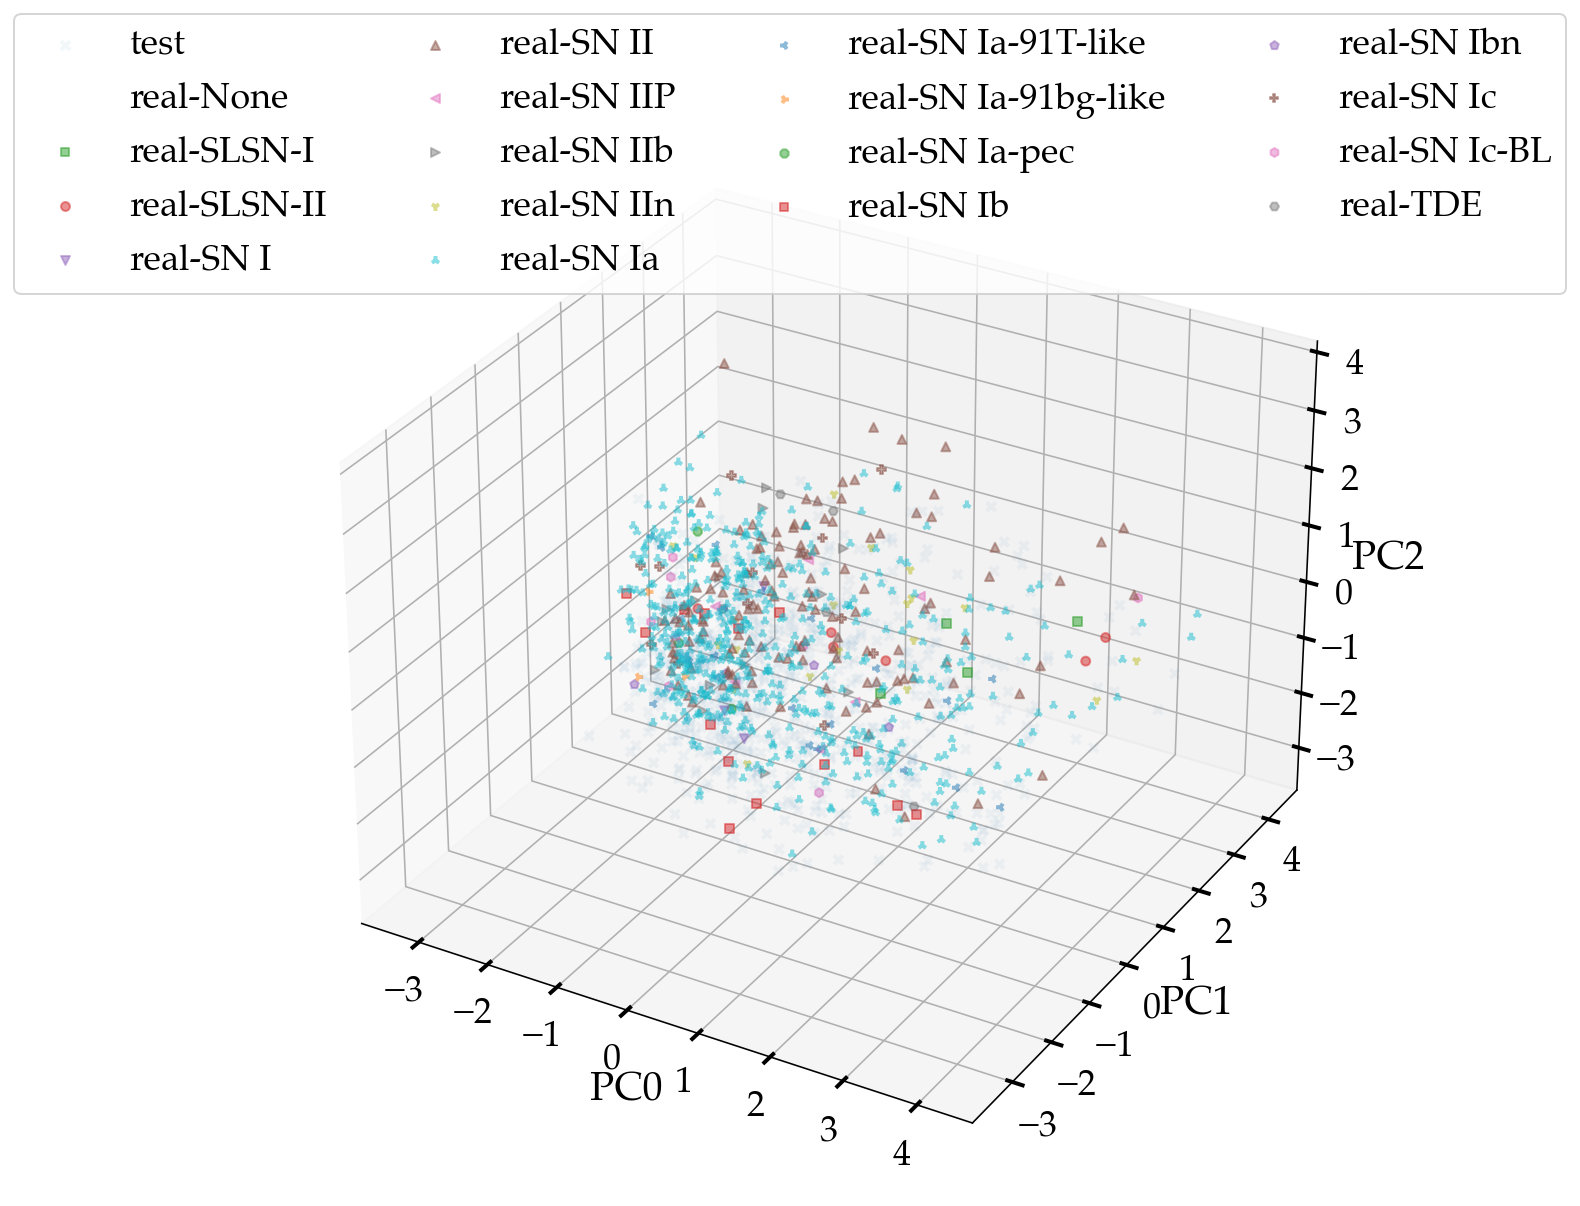

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], test_df['PC2'], alpha=0.05, marker='x', label='test')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    
    if cls == 'None': ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], real_cls_df['PC2'], alpha=0.0, marker=marker, label=f'real-{cls}')
    else: ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], real_cls_df['PC2'], alpha=0.5, marker=marker, label=f'real-{cls}')

# ax.scatter(real_df['PC0'], real_df['PC1'], real_df['PC2'], alpha=0.2, marker='*', label='real')
# ax.scatter(test_df['PC0'], test_df['PC1'], test_df['PC2'], alpha=0.05, marker='x', label='test')

# Set axis limits
ax.set_xlim(real_df['PC0'].min(), real_df['PC0'].max())
ax.set_ylim(real_df['PC1'].min(), real_df['PC1'].max())
ax.set_zlim(real_df['PC2'].min(), real_df['PC2'].max())

ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.1))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df_no_real_3D.jpg', dpi=250, bbox_inches='tight')
plt.show()


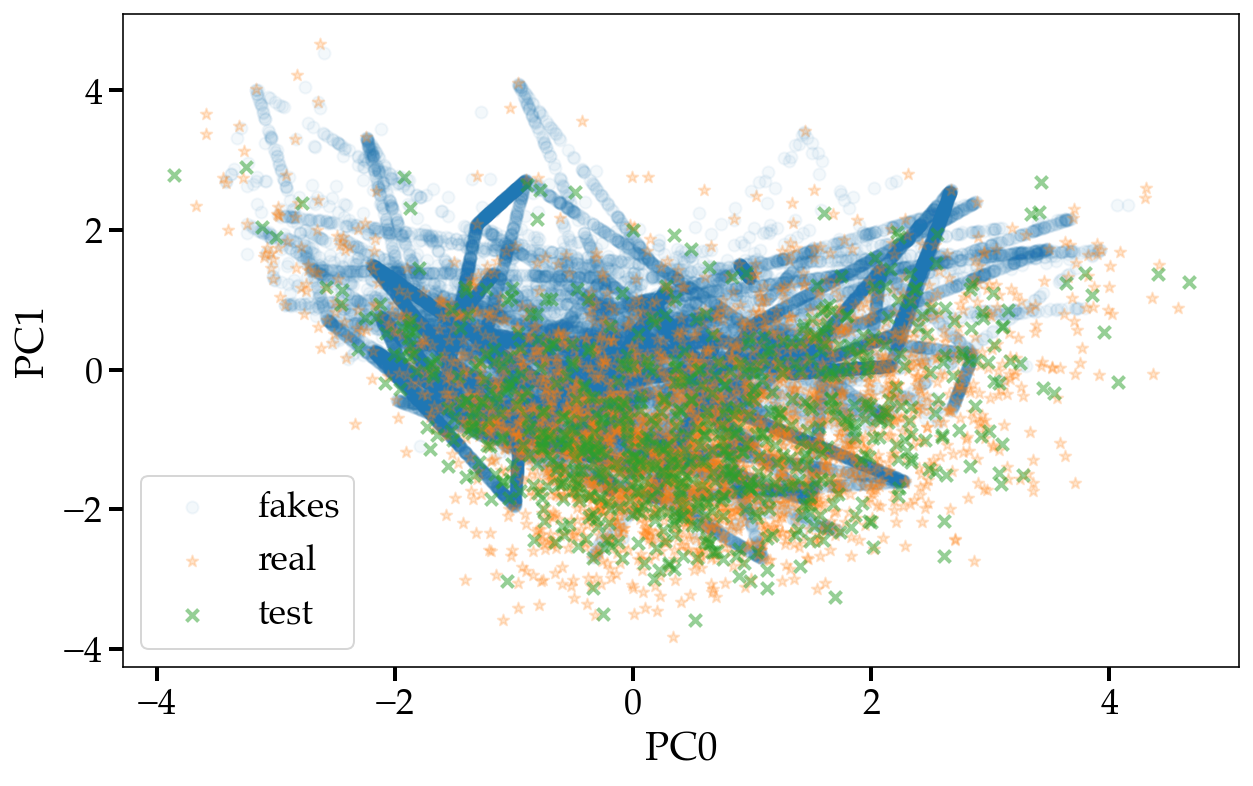

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.5, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend()
plt.savefig(f'../figures/principal_components/{suffix}/real_vs_fakes_vs_test.jpg', dpi=250, bbox_inches='tight')
plt.show()

In [15]:
#cut_df = test_df[(test_df['PC0'] > 4)]
cut_df = real_df[(real_df['PC0'] > 4)]

cut_df

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF19aaafhbf   4.005756  1.485073 -0.632986 -0.353348  1.067913  0.311980   
ZTF21aabjajq   4.022257  0.789353  1.146471 -0.020809  0.437338 -0.203802   
ZTF21aalimtb   4.085673  1.681646  1.208173  0.025096  0.311502  0.033183   
ZTF21abctjuo   4.413800  1.498318 -0.224523 -0.215274  1.021194  0.114613   
ZTF21aasbajb   4.367626 -0.066756 -0.494135  0.879467  1.268348 -0.365379   
ZTF21abbwbja   4.306613  2.598349  0.606359 -0.947515  0.917345  0.976373   
ZTF21aarozav   4.572527  0.884624  0.657170  0.024590  0.942551 -0.257986   
ZTF21aaxgwtb   4.297365  2.464576  0.281112 -1.387566  1.384528  0.549007   
ZTF19aasalud   4.357738  1.025968 -0.092839 -0.236475  1.402749  0.113116   

                    PC6       PC7       PC8       PC9  ...      PC26  \
ztf_object_id                                          ...             
ZTF19aaafhbf  -0.649708  0.399653  0.053596 -0.755557  ... -0.208216   
ZTF21aabjajq  -0.215859 -0.153035  0.179359  0.407153  ...  0.192046   
ZTF21aalimtb  -0.422904  0.370269  0.507867  0.207752  ...  0.336159   
ZTF21abctjuo  -0.301268  0.757046  0.165812 -0.544579  ... -0.187522   
ZTF21aasbajb  -0.946118  1.046584 -0.293110  0.262584  ... -0.049286   
ZTF21abbwbja  -0.152172  0.447955  0.264011 -0.151140  ... -0.152532   
ZTF21aarozav   0.260586  0.400076  0.251244  0.323795  ... -0.076627   
ZTF21aaxgwtb  -0.163891  0.740687  0.114529 -0.278009  ... -0.182175   
ZTF19aasalud  -0.444939  1.228125 -0.157812  0.590550  ... -0.161336   

                   PC27      PC28      PC29      PC30      PC31      PC32  \
ztf_object_id                                                               
ZTF19aaafhbf   0.180523 -0.189239 -0.284500  0.059180  0.205331 -0.016880   
ZTF21aabjajq  -0.199621 -0.239692  0.087162  0.118867 -0.065778 -0.029661   
ZTF21aalimtb  -0.179368 -0.523510  0.015690  0.068702  0.248135 -0.026191   
ZTF21abctjuo   0.020224 -0.342421  0.011204  0.031385  0.102467 -0.011713   
ZTF21aasbajb  -0.113553  0.154920  0.067734  0.169559 -0.090078  0.242119   
ZTF21abbwbja  -0.275173 -0.248835  0.182035 -0.129878  0.074922 -0.070786   
ZTF21aarozav  -0.113474 -0.341363  0.093405  0.002305 -0.138713  0.042167   
ZTF21aaxgwtb  -0.107985 -0.197867  0.116384 -0.222362  0.073401 -0.148967   
ZTF19aasalud  -0.034505 -0.364503  0.020875  0.177253  0.073568  0.079104   

                   PC33      PC34  tns_cls  
ztf_object_id                               
ZTF19aaafhbf  -0.130710  0.142895     None  
ZTF21aabjajq  -0.066954  0.025642     None  
ZTF21aalimtb   0.206575  0.163780     None  
ZTF21abctjuo   0.037520  0.287887     None  
ZTF21aasbajb   0.319381  0.433300     None  
ZTF21abbwbja   0.045430  0.366357    SN Ia  
ZTF21aarozav   0.047270  0.364935     None  
ZTF21aaxgwtb   0.125582  0.303488    SN Ia  
ZTF19aasalud   0.091449  0.254934     None  

[9 rows x 36 columns]

In [16]:
for sn, cl in zip(cut_df.index, cut_df.tns_cls):
    print(f'https://alerce.online/object/{sn}', cl)

https://alerce.online/object/ZTF19aaafhbf None
https://alerce.online/object/ZTF21aabjajq None
https://alerce.online/object/ZTF21aalimtb None
https://alerce.online/object/ZTF21abctjuo None
https://alerce.online/object/ZTF21aasbajb None
https://alerce.online/object/ZTF21abbwbja SN Ia
https://alerce.online/object/ZTF21aarozav None
https://alerce.online/object/ZTF21aaxgwtb SN Ia
https://alerce.online/object/ZTF19aasalud None


In [13]:
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20"

In [14]:
# train/test before smote has same embedding mostly
# smote covers regions it's supposed to

In [15]:
test_df[(test_df['PC0'] > 20) & (test_df['PC1'] < -20)]

Empty DataFrame
Columns: [PC0, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17, PC18, PC19, PC20, PC21, PC22, PC23, PC24, PC25, PC26, PC27, PC28, PC29, PC30, PC31, PC32, PC33, PC34, tns_cls]
Index: []

[0 rows x 36 columns]

In [10]:
# https://alerce.online/object/ZTF18abdhozj - remaining periodic var
# https://alerce.online/object/ZTF20acqucpz - remaining CV

In [12]:
real_df[(real_df['PC0'] < -20) & (real_df['PC1'] > 15)]

PC0        PC1        PC2       PC3       PC4       PC5  \
ztf_object_id                                                                  
ZTF21abdtkdc  -22.163253  22.511544  -7.627958 -2.259726 -3.433426 -2.808574   
ZTF21aarvysz  -20.838052  19.716343 -11.223825 -9.730916 -4.214124 -2.776630   
ZTF21aardzlu  -20.609653  17.887838  -1.452162 -1.571780  5.446219 -0.511114   

                    PC6       PC7       PC8       PC9  ...      PC35  \
ztf_object_id                                          ...             
ZTF21abdtkdc  -4.373169  0.230342  6.517101 -1.174292  ...  1.207785   
ZTF21aarvysz  -2.469222  4.432431  3.459800 -0.015755  ... -0.822607   
ZTF21aardzlu  -2.816245 -0.564413  3.411933  1.063307  ...  0.949911   

                   PC36      PC37      PC38      PC39      PC40      PC41  \
ztf_object_id                                                               
ZTF21abdtkdc  -0.965603  2.253548  1.345902 -2.990527 -1.364164 -2.640205   
ZTF21aarvysz   0.529747  2.099676  0.324822 -0.193822 -0.413322 -3.663055   
ZTF21aardzlu  -0.015324 -1.113844 -0.854960  0.542895 -1.589053 -0.632498   

                   PC42      PC43      PC44  
ztf_object_id                                
ZTF21abdtkdc   0.319725 -1.411165 -0.142190  
ZTF21aarvysz   1.086797 -0.874276 -0.521186  
ZTF21aardzlu   0.795945 -1.980645 -0.460658  

[3 rows x 45 columns]

In [ ]:
# all 3 are flat LCs with None tns spec class

In [14]:
test_df[(test_df['PC0'] < 10) & (test_df['PC1'] > 20)]

PC0        PC1        PC2        PC3      PC4       PC5  \
ztf_object_id                                                                 
ZTF18abwxrhi   4.527623  21.511848  18.555454  11.050699  4.83806 -4.791629   

                     PC6        PC7       PC8       PC9  ...      PC35  \
ztf_object_id                                            ...             
ZTF18abwxrhi   21.238319  19.539585 -4.750731 -5.895489  ... -2.344125   

                   PC36      PC37      PC38      PC39      PC40      PC41  \
ztf_object_id                                                               
ZTF18abwxrhi  -2.972335  3.366347 -0.763277 -1.839438 -1.142456  3.152264   

                   PC42      PC43      PC44  
ztf_object_id                                
ZTF18abwxrhi   1.380873  2.985124  3.431534  

[1 rows x 45 columns]

In [ ]:
# https://alerce.online/object/ZTF18abwxrhi
# that weird maybe double peak SN / bogus second bump obs

In [16]:
test_df[(test_df['PC0'] < -25) & (test_df['PC1'] < -10)]

PC0        PC1        PC2       PC3        PC4       PC5  \
ztf_object_id                                                                   
ZTF18aaqdlle  -29.344679 -11.608744  10.294377 -2.510227  26.038514  2.667018   
ZTF18acclacc  -29.015988 -16.451279   5.987124  1.856043  21.864505 -1.625007   

                    PC6       PC7       PC8       PC9  ...      PC35  \
ztf_object_id                                          ...             
ZTF18aaqdlle   0.422067  5.172922  3.517185 -0.851667  ... -2.391525   
ZTF18acclacc   3.249946  9.712309  5.493366  2.360775  ... -2.382828   

                   PC36      PC37      PC38      PC39      PC40      PC41  \
ztf_object_id                                                               
ZTF18aaqdlle  -1.821549 -0.830398 -0.426677  0.503373  0.106479 -1.140716   
ZTF18acclacc   0.074992  0.530949 -1.617456 -0.956524 -2.599603 -0.943605   

                   PC42      PC43      PC44  
ztf_object_id                                
ZTF18aaqdlle   0.549167 -2.004430  1.444579  
ZTF18acclacc   0.078554 -2.304119  0.805382  

[2 rows x 45 columns]

In [ ]:
# SN in template images

In [17]:
test_df[(test_df['PC0'] < -20) & (test_df['PC1'] < -10)]

PC0        PC1        PC2        PC3        PC4  \
ztf_object_id                                                          
ZTF21aasttsm  -20.298472 -11.896813  11.995602 -11.060080   1.215294   
ZTF21abrduyv  -24.222897 -14.482757   9.234705   3.250013   3.324799   
ZTF21aaqhxvc  -22.256702 -14.075184   3.824647   7.586351   3.233600   
ZTF18aaqdlle  -29.344679 -11.608744  10.294377  -2.510227  26.038514   
ZTF18acclacc  -29.015988 -16.451279   5.987124   1.856043  21.864505   
ZTF21abcwnub  -20.716612 -10.193120   2.729436  -3.701176   0.192830   

                    PC5       PC6       PC7       PC8       PC9  ...  \
ztf_object_id                                                    ...   
ZTF21aasttsm  -1.563570 -3.610145 -6.124563  1.568291  3.397161  ...   
ZTF21abrduyv   1.948191 -2.928338  0.997722 -3.465844  0.748486  ...   
ZTF21aaqhxvc  -0.435544  1.882573 -0.221733  2.065071 -0.445902  ...   
ZTF18aaqdlle   2.667018  0.422067  5.172922  3.517185 -0.851667  ...   
ZTF18acclacc  -1.625007  3.249946  9.712309  5.493366  2.360775  ...   
ZTF21abcwnub  -1.169605 -1.817422  1.924119 -2.593268 -0.191790  ...   

                   PC35      PC36      PC37      PC38      PC39      PC40  \
ztf_object_id                                                               
ZTF21aasttsm   2.120320  1.851662  0.597470  0.474003 -1.956241  0.637700   
ZTF21abrduyv   1.806170  0.148293 -2.418226  1.868700 -3.024807  0.368600   
ZTF21aaqhxvc  -0.848070  0.833937 -3.098243 -0.176281  0.424199  0.163895   
ZTF18aaqdlle  -2.391525 -1.821549 -0.830398 -0.426677  0.503373  0.106479   
ZTF18acclacc  -2.382828  0.074992  0.530949 -1.617456 -0.956524 -2.599603   
ZTF21abcwnub   0.801612 -0.347447 -1.637663  0.352083 -1.687103 -0.606164   

                   PC41      PC42      PC43      PC44  
ztf_object_id                                          
ZTF21aasttsm   1.965622  3.005612 -1.149632 -0.702561  
ZTF21abrduyv   0.244908 -0.247381  0.245462  1.318686  
ZTF21aaqhxvc   1.152259 -1.147861 -0.593108  1.061885  
ZTF18aaqdlle  -1.140716  0.549167 -2.004430  1.444579  
ZTF18acclacc  -0.943605  0.078554 -2.304119  0.805382  
ZTF21abcwnub   1.077189 -0.676988  0.659723 -1.162769  

[6 rows x 45 columns]

In [ ]:
# ALL ZTF21 LCs are rising and top out before 2nd peak, tightly sampled Ia in small elliptical galaxies

# 2 PCs (43% of variance) do pretty good job.